In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install kaggle --upgrade

In [ ]:
# 아하.. 내 캐글 API를 넣는 거였다!
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sunmyyii","key":"2f3035b754d71b6997a01f6acd570181"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!ls -1ha kaggle.json


kaggle.json


In [ ]:
!kaggle datasets download -d alirakhmaev/ucf-crime-full

 85% 20.8G/24.4G [04:36<01:22, 48.2MB/s]

In [ ]:
# 빈 폴더 생성
!mkdir -p /content/ucf-crime-full

# 압축 해제
!unzip /content/ucf-crime-full.zip -d /content/ucf-crime-full

### 참고 자료 : <a href='https://www.youtube.com/watch?v=QmtSkq3DYko'>Human Activity Recognition using TensorFlow (CNN + LSTM) | 2 Methods
</a>

### Data : https://www.kaggle.com/datasets/alirakhmaev/ucf-crime-full

In [ ]:
# Import the required libraries.
import os
import cv2
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

In [ ]:
import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

In [ ]:
seed_constant = 42
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

In [ ]:
IMAGE_HEIGHT , IMAGE_WIDTH = 64, 64
# Error : Your notebook tried to allocate more memory than is available. It has restarted.

# 시퀀스로 공급될 비디오 프레임 수
SEQUENCE_LENGTH = 200

DATASET_DIR = "/content/ucf-crime-full"
CLASSES_LIST = sorted([entry.name for entry in os.scandir(DATASET_DIR) if entry.is_dir()])

In [ ]:
CLASSES_LIST

In [ ]:
def display_random_video_frames(dataset_dir, num_classes, rows, cols):
    '''
    Display randomly selected video frames from randomly selected classes.
    Args:
        dataset_dir: Path to the directory containing the dataset.
        num_classes: Number of classes to display (default is 6).
        rows: Number of rows in the display grid (default is 2).
        cols: Number of columns in the display grid (default is 3).
    '''

    # Get the list of all class names in the dataset directory.
    all_classes_names = os.listdir(dataset_dir)

    # Randomly select num_classes classes.
    random_classes = random.sample(all_classes_names, num_classes)

    # Create a Matplotlib figure and specify the size of the figure.
    plt.figure(figsize=(15, 10))

    # Iterate through the selected classes.
    for i, class_name in enumerate(random_classes, 1):

        # Get the list of video files in the current class directory.
        video_files_names_list = os.listdir(os.path.join(dataset_dir, class_name))

        # Randomly select a video file from the class directory.
        selected_video_file_name = random.choice(video_files_names_list)

        # Initialize a VideoCapture object to read from the video file.
        video_reader = cv2.VideoCapture(os.path.join(dataset_dir, class_name, selected_video_file_name))

        # Read the first frame of the video file.
        _, bgr_frame = video_reader.read()

        # Release the VideoCapture object.
        video_reader.release()

        # Convert the frame from BGR to RGB format.
        rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)

        # Write the class name on the video frame.
        cv2.putText(rgb_frame, class_name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 102, 102), 2)

        # Display the frame.
        plt.subplot(rows, cols, i)
        plt.imshow(rgb_frame)
        plt.axis('off')

    # Show the plot.
    plt.tight_layout()
    plt.show()



In [ ]:
display_random_video_frames(DATASET_DIR, num_classes=6, rows=2, cols=3)

In [ ]:
def frames_extraction(video_path, max_video_frame_length=2000):
    '''
    This function will extract the required frames from a video after resizing and normalizing them.
    Args:
        video_path: The path of the video in the disk, whose frames are to be extracted.
        max_video_length: Maximum video length in seconds (default is 60 seconds).
    Returns:
        frames_list: A list containing the resized and normalized frames of the video.
    '''

    # Declare a list to store video frames.
    frames_list = []

    # Read the Video File using the VideoCapture object.
    video_reader = cv2.VideoCapture(video_path)

    # Get the total number of frames in the video.
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    # If the video length exceeds the maximum allowed, return empty frames_list.
    if video_frames_count > max_video_frame_length:
        video_reader.release()
        return frames_list

    # Calculate the interval after which frames will be added to the list.
    skip_frames_window = max(int(video_frames_count / SEQUENCE_LENGTH), 1)

    # Iterate through the Video Frames.
    for frame_counter in range(SEQUENCE_LENGTH):

        # Set the current frame position of the video.
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

        # Reading the frame from the video.
        success, frame = video_reader.read()

        # Check if Video frame is not successfully read then break the loop
        if not success:
            break

        # Resize the Frame to fixed height and width.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))

        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1
        normalized_frame = resized_frame / 255

        # Append the normalized frame into the frames list
        frames_list.append(normalized_frame)

    # Release the VideoCapture object.
    video_reader.release()

    # Return the frames list.
    return frames_list



In [ ]:
from tqdm import tqdm

def create_dataset():
    '''
    This function will extract the data of the selected classes and create the required dataset.
    Returns:
        features:          A list containing the extracted frames of the videos.
        labels:            A list containing the indexes of the classes associated with the videos.
        video_files_paths: A list containing the paths of the videos in the disk.
    '''
    # Declared Empty Lists to store the features, labels and video file path values.
    features = []
    labels = []
    video_files_paths = []
    max_length_video_dict = {}

    # Iterating through all the classes mentioned in the classes list
    for class_index, class_name in tqdm(enumerate(CLASSES_LIST[:5])): # 메모리 문제로 6개의 클래스만 사용
        max_length_video_cnt = 0

        # Display the name of the class whose data is being extracted.
        print(f'Extracting Data of Class: {class_name}')

        # Get the list of video files present in the specific class name directory.
        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))

        # Counter to keep track of the number of videos extracted for each class
#         video_count = 0

        # Iterate through all the files present in the files list.
        for file_name in files_list:

            # Get the complete video path.
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)

            # Extract the frames of the video file.
            # 동영상의 시간은 30초부터 1분 30초 까지 다양합니다
            # 동영상의 총 프레임 수가 2500 이하인 프레임만 사용합니다
            frames = frames_extraction(video_file_path, 2500)


            if len(frames) == SEQUENCE_LENGTH:

                # Append the data to their repective lists.
                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)
            else:
                max_length_video_cnt+=1
                max_length_video_dict[class_name] = max_length_video_cnt


    features = np.asarray(features)
    labels = np.array(labels)
    print('Video over max frame   : ',max_length_video_dict)

    # Return the frames, class index, and video file path.
    return features, labels, video_files_paths

In [ ]:
features, labels, video_files_paths = create_dataset()

In [ ]:
import pickle

# 데이터를 저장할 파일 경로
output_file_path = "/content/ucf_crime_full_data.pkl"

# 데이터를 하나의 딕셔너리로 묶어준다고 가정합니다.
data = {
    "features": features,
    "labels": labels,
    "video_files_paths": video_files_paths
}

# 데이터 저장
with open(output_file_path, "wb") as output_file:
    pickle.dump(data, output_file)

print("Data saved to", output_file_path)

In [ ]:
# Using Keras's to_categorical method to convert labels into one-hot-encoded vectors
one_hot_encoded_labels = to_categorical(labels)

In [ ]:
# Split the Data into Train ( 80% ) and Test Set ( 20% ).
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels,
                                                                            test_size = 0.2, shuffle = True,
                                                                            random_state = seed_constant)

In [ ]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
    '''
    This function will plot the metrics passed to it in a graph.
    Args:
        model_training_history: A history object containing a record of training and validation
                                loss values and metrics values at successive epochs
        metric_name_1:          The name of the first metric that needs to be plotted in the graph.
        metric_name_2:          The name of the second metric that needs to be plotted in the graph.
        plot_name:              The title of the graph.
    '''

    # Get metric values using metric names as identifiers.
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]

    # Construct a range object which will be used as x-axis (horizontal plane) of the graph.
    epochs = range(len(metric_value_1))

    # Plot the Graph.
    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)

    # Add title to the plot.
    plt.title(str(plot_name))

    # Add legend to the plot.
    plt.legend()

CNN은 네트워크에 단시간 정보를 구현할 수 있지만 전체 데이터의 시간 정보를 모델링하기는 어렵다. 반면 LSTM은 장기간 데이터 모델링에 적합하지만 공간정보를 학습하기 어렵다. 따라서 행동 특성을 추출하고 시간 매커니즘을 파악하기 위해 두 방법을 결합한 LRCN 모델을 사용한다.

### LRCN (Long-Term Recurrent Convolutional Networks)

LRCN은 합성곱(Convolutional) 레이어와 장기적인 시간적 연속성을 다루기 위한 순환(RNN) 레이어를 조합한 구조입니다.

연속적인 이미지로 이루어진 비디오 데이터를 처리하는데 사용되는 모델입니다.
비디오에서 나타나는 변화를 포착하고 시간적 패턴을 학습하여 영상 데이터를 분류하는 역할을 수행합니다.
일련의 이미지 프레임을 입력으로 받아들이고, 이를 순차적으로 처리하여 비디오의 특징을 추출합니다.

<img src = 'https://velog.velcdn.com/images/jyunxx/post/604e38c4-4b11-4bf1-af00-46994fe35737/image.png'>


In [ ]:
def create_LRCN_model():
    '''
    This function will construct the required LRCN model.
    Returns:
        model: It is the required constructed LRCN model.
    '''

    # We will use a Sequential model for model construction.
    model = Sequential()

    # Define the Model Architecture.
    ########################################################################################################################

    model.add(TimeDistributed(Conv2D(16, (3, 3), padding='same',activation = 'relu'),
                              input_shape = (SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))

    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    #model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Flatten()))

    model.add(LSTM(32))

    model.add(Dropout(0.5)) ##### 추가

    model.add(Dense(len(CLASSES_LIST[:5]), activation = 'softmax'))

    ########################################################################################################################

    # Display the models summary.
    model.summary()

    # Return the constructed LRCN model.
    return model

Convolutional Neural Network (CNN)을 이용해 각 프레임에서 공간적인 특징을 추출하고, 그 다음 TimeDistributed를 이용하여 시간적인 연속성을 유지하면서 각 프레임에 적용합니다.

그리고 LSTM을 이용하여 이전 프레임의 정보를 현재 프레임에 전달하면서 시퀀스의 패턴을 학습합니다.

마지막으로는 LSTM의 출력을 기반으로 분류를 수행하는 Fully Connected Layer가 추가되어 클래스를 예측합니다.

In [ ]:
# Construct the required LRCN model.
LRCN_model = create_LRCN_model()

# Display the success message.
print("Model Created Successfully!")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 200, 64, 64, 16)  448       
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 200, 16, 16, 16)  0         
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 200, 16, 16, 16)  0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 200, 16, 16, 32)  4640      
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 200, 4, 4, 32)    0

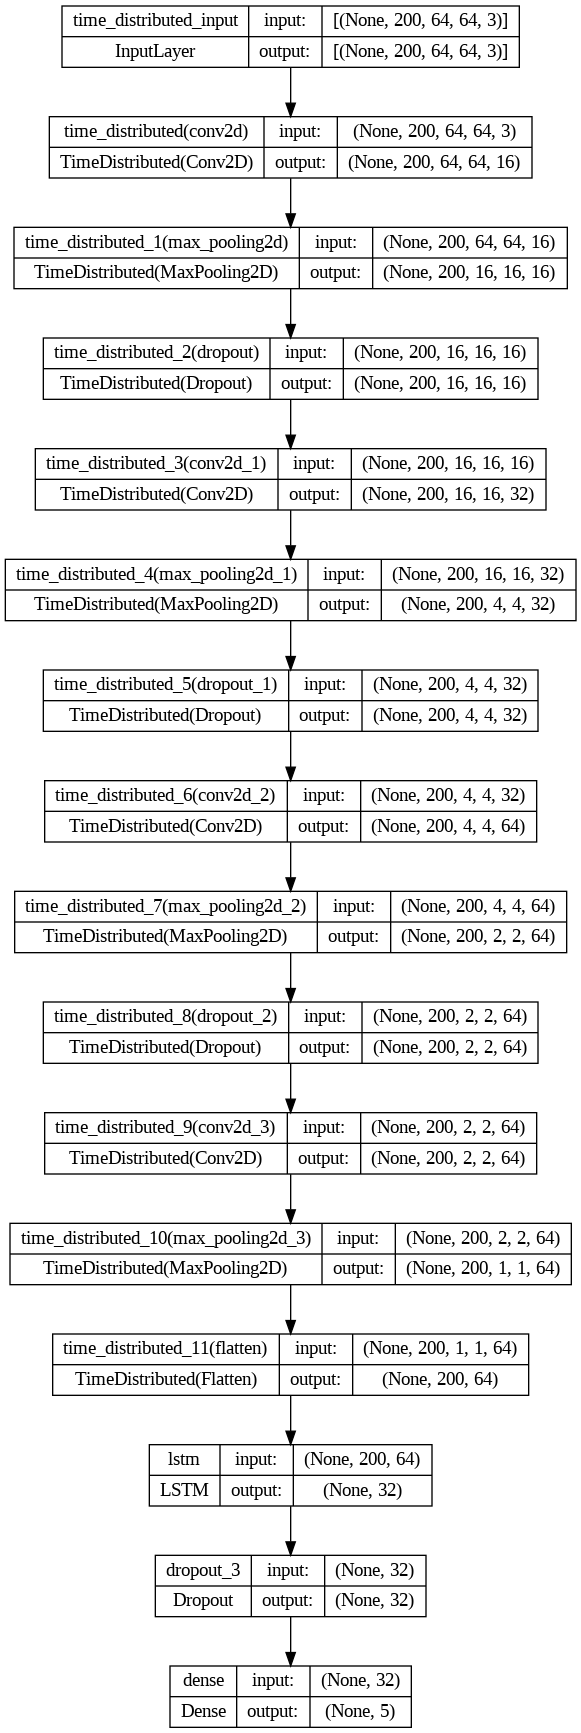

In [ ]:
# Plot the structure of the contructed LRCN model.
plot_model(LRCN_model, to_file = 'LRCN_model_structure_plot.png', show_shapes = True, show_layer_names = True)

# dropout(0.5) 추가, batch size 4

In [ ]:
# Create an Instance of Early Stopping Callback.
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 50, mode = 'min', restore_best_weights = True)

# Compile the model and specify loss function, optimizer and metrics to the model.
LRCN_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

batch_size = 4

# Start training the model.
LRCN_model_training_history = LRCN_model.fit(x = features_train, y = labels_train, epochs = 100, batch_size = batch_size ,
                                             shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback])

Epoch 1/100
23/23 [==============================] - 21s 82ms/step - loss: 1.6498 - accuracy: 0.3152 - val_loss: 1.5493 - val_accuracy: 0.2083
Epoch 2/100
23/23 [==============================] - 1s 47ms/step - loss: 1.5828 - accuracy: 0.2500 - val_loss: 1.5740 - val_accuracy: 0.4583
Epoch 3/100
23/23 [==============================] - 1s 48ms/step - loss: 1.6077 - accuracy: 0.1739 - val_loss: 1.5665 - val_accuracy: 0.4583
Epoch 4/100
23/23 [==============================] - 1s 47ms/step - loss: 1.6028 - accuracy: 0.2609 - val_loss: 1.5790 - val_accuracy: 0.4583
Epoch 5/100
23/23 [==============================] - 1s 48ms/step - loss: 1.5906 - accuracy: 0.2609 - val_loss: 1.5466 - val_accuracy: 0.4583
Epoch 6/100
23/23 [==============================] - 1s 48ms/step - loss: 1.5993 - accuracy: 0.2391 - val_loss: 1.5752 - val_accuracy: 0.3750
Epoch 7/100
23/23 [==============================] - 1s 48ms/step - loss: 1.5505 - accuracy: 0.3587 - val_loss: 1.5282 - val_accuracy: 0.2500
Epoch

In [ ]:
# Evaluate the trained model.
model_evaluation_history = LRCN_model.evaluate(features_test, labels_test)

1/1 [==============================] - 2s 2s/step - loss: 1.5099 - accuracy: 0.4138


In [ ]:
# Get the loss and accuracy from model_evaluation_history.
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history

# Define the string date format.
# Get the current Date and Time in a DateTime Object.
# Convert the DateTime object to string according to the style mentioned in date_time_format string.
date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)

# Define a useful name for our model to make it easy for us while navigating through multiple saved models.
model_file_name = f'LRCN_model___Date_Time_{current_date_time_string}___Loss_{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}___BatchSize_{batch_size}___AddDropout(0.5).h5'

# Save the Model.
model_file_path = '/content/drive/MyDrive/Final_team_3/Code/Sunmyeong/LRCN_model/' + model_file_name
LRCN_model.save(model_file_path)

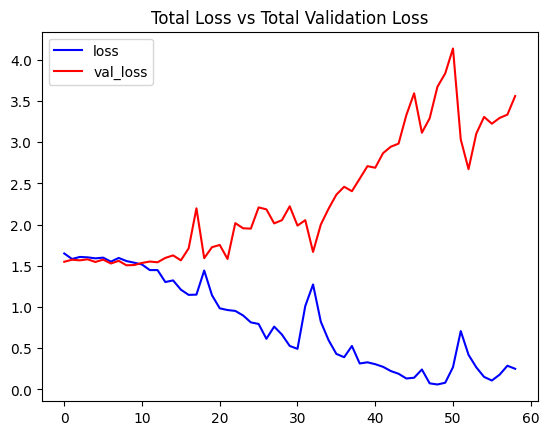

In [ ]:
# Visualize the training and validation loss metrices.
plot_metric(LRCN_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

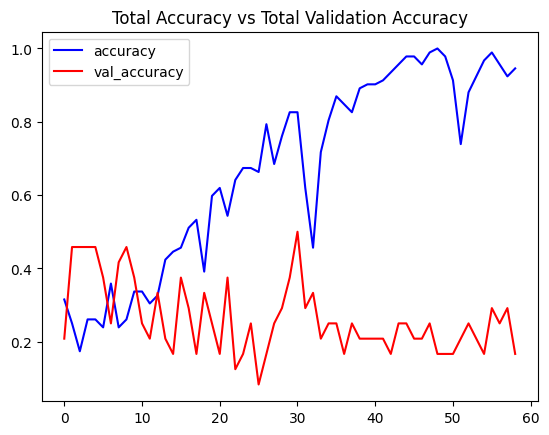

In [ ]:
# Visualize the training and validation accuracy metrices.
plot_metric(LRCN_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')

# dropout(0.5) 추가, batch_size=8

In [ ]:
# Create an Instance of Early Stopping Callback.
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 50, mode = 'min', restore_best_weights = True)

# Compile the model and specify loss function, optimizer and metrics to the model.
LRCN_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

batch_size = 8

# Start training the model.
LRCN_model_training_history = LRCN_model.fit(x = features_train, y = labels_train, epochs = 100, batch_size = batch_size ,
                                             shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback])

Epoch 1/100
12/12 [==============================] - 7s 160ms/step - loss: 1.5035 - accuracy: 0.3152 - val_loss: 1.5065 - val_accuracy: 0.2917
Epoch 2/100
12/12 [==============================] - 1s 97ms/step - loss: 1.4715 - accuracy: 0.4022 - val_loss: 1.5319 - val_accuracy: 0.2500
Epoch 3/100
12/12 [==============================] - 1s 97ms/step - loss: 1.4620 - accuracy: 0.3913 - val_loss: 1.5801 - val_accuracy: 0.1667
Epoch 4/100
12/12 [==============================] - 1s 98ms/step - loss: 1.4391 - accuracy: 0.3370 - val_loss: 1.5275 - val_accuracy: 0.3333
Epoch 5/100
12/12 [==============================] - 1s 98ms/step - loss: 1.4076 - accuracy: 0.3587 - val_loss: 1.5718 - val_accuracy: 0.2083
Epoch 6/100
12/12 [==============================] - 1s 98ms/step - loss: 1.3833 - accuracy: 0.3478 - val_loss: 1.5048 - val_accuracy: 0.3750
Epoch 7/100
12/12 [==============================] - 1s 97ms/step - loss: 1.2234 - accuracy: 0.4674 - val_loss: 1.5915 - val_accuracy: 0.2500
Epoch

In [ ]:
# Evaluate the trained model.
model_evaluation_history = LRCN_model.evaluate(features_test, labels_test)

1/1 [==============================] - 1s 823ms/step - loss: 1.4283 - accuracy: 0.4828


In [ ]:
# Get the loss and accuracy from model_evaluation_history.
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history

# Define the string date format.
# Get the current Date and Time in a DateTime Object.
# Convert the DateTime object to string according to the style mentioned in date_time_format string.
date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)

# Define a useful name for our model to make it easy for us while navigating through multiple saved models.
model_file_name = f'LRCN_model___Date_Time_{current_date_time_string}___Loss_{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}___BatchSize_{batch_size}___AddDropout(0.5).h5'

# Save the Model.
model_file_path = '/content/drive/MyDrive/Final_team_3/Code/Sunmyeong/LRCN_model/' + model_file_name
LRCN_model.save(model_file_path)

### 모델 성능 상승을 위한 방법

- 더 깊은 CNN 레이어 추가: CNN 레이어를 더 깊게 쌓거나, 더 많은 필터를 사용하여 이미지의 특징을 더 잘 추출하도록 할 수 있습니다. 하지만 레이어를 깊게 쌓을 때는 과적합에 주의해야 합니다.

- LSTM 레이어 수정: LSTM 레이어의 유닛 수를 조정하거나, 레이어를 여러 개 쌓아보는 등의 변경을 통해 모델의 표현 능력을 높일 수 있습니다.

- 정규화와 드롭아웃 사용: CNN과 LSTM 레이어 사이에 배치 정규화나 드롭아웃과 같은 regularization 기법을 추가하여 과적합을 줄일 수 있습니다.

- 다양한 옵티마이저 시도: 모델의 수렴 속도와 성능은 사용하는 옵티마이저에 따라 달라질 수 있습니다. Adam이나 RMSProp 등의 다양한 옵티마이저를 시도해보며 성능을 확인할 수 있습니다.

- 데이터 확장: 데이터 증강(data augmentation) 기법을 활용하여 데이터셋을 더 다양하게 만들어 모델의 일반화 성능을 향상시킬 수 있습니다.

- 미세 조정 (Fine-tuning): 사전 훈련된 CNN 모델을 사용하고 있다면, 이 모델의 일부 레이어를 고정시키고 일부 레이어만 훈련시켜 모델을 조정할 수 있습니다.

- 하이퍼파라미터 조정: 학습률, 배치 크기, 에포크 수 등과 같은 하이퍼파라미터들을 조정하며 최적의 조합을 찾아볼 수 있습니다.

- 다른 모델 아키텍처 시도: LSTM 외에도 다른 RNN 계열 모델이나, Transformer와 같은 최신 아키텍처를 시도하여 성능을 비교해 볼 수 있습니다.

- 앙상블: 여러 모델의 예측을 결합하여 더 강력한 모델을 생성하는 앙상블을 시도할 수 있습니다.

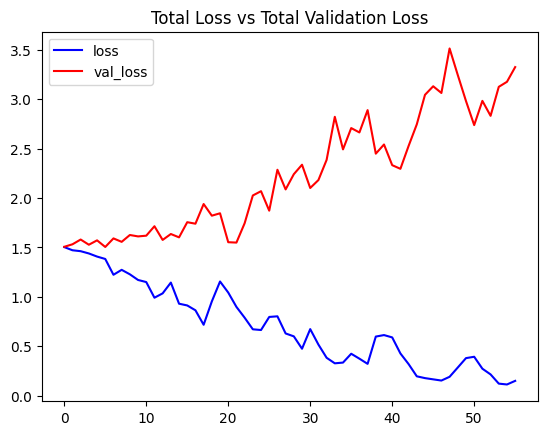

In [ ]:
# Visualize the training and validation loss metrices.
plot_metric(LRCN_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

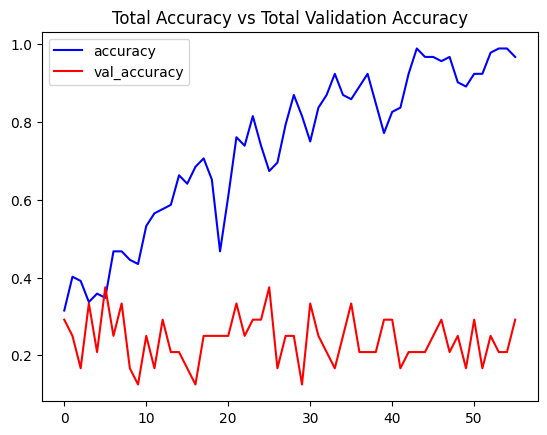

In [ ]:
# Visualize the training and validation accuracy metrices.
plot_metric(LRCN_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')

# dropout 0.5, batch size 16

In [ ]:
# Create an Instance of Early Stopping Callback.
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 50, mode = 'min', restore_best_weights = True)

# Compile the model and specify loss function, optimizer and metrics to the model.
LRCN_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

batch_size = 16

# Start training the model.
LRCN_model_training_history = LRCN_model.fit(x = features_train, y = labels_train, epochs = 100, batch_size = batch_size ,
                                             shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback])

Epoch 1/100
6/6 [==============================] - 10s 792ms/step - loss: 1.3640 - accuracy: 0.3370 - val_loss: 1.5270 - val_accuracy: 0.3750
Epoch 2/100
6/6 [==============================] - 1s 201ms/step - loss: 1.2648 - accuracy: 0.4565 - val_loss: 1.6065 - val_accuracy: 0.2917
Epoch 3/100
6/6 [==============================] - 1s 199ms/step - loss: 1.2485 - accuracy: 0.4457 - val_loss: 1.5937 - val_accuracy: 0.2917
Epoch 4/100
6/6 [==============================] - 1s 201ms/step - loss: 1.2282 - accuracy: 0.4239 - val_loss: 1.6250 - val_accuracy: 0.2917
Epoch 5/100
6/6 [==============================] - 1s 199ms/step - loss: 1.1312 - accuracy: 0.5000 - val_loss: 1.6161 - val_accuracy: 0.2917
Epoch 6/100
6/6 [==============================] - 1s 199ms/step - loss: 1.1063 - accuracy: 0.5652 - val_loss: 1.6372 - val_accuracy: 0.2917
Epoch 7/100
6/6 [==============================] - 1s 185ms/step - loss: 1.0115 - accuracy: 0.5761 - val_loss: 1.6327 - val_accuracy: 0.2917
Epoch 8/100


In [ ]:
# Evaluate the trained model.
model_evaluation_history = LRCN_model.evaluate(features_test, labels_test)

1/1 [==============================] - 0s 322ms/step - loss: 1.4500 - accuracy: 0.4138


In [ ]:
# Get the loss and accuracy from model_evaluation_history.
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history

# Define the string date format.
# Get the current Date and Time in a DateTime Object.
# Convert the DateTime object to string according to the style mentioned in date_time_format string.
date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)

# Define a useful name for our model to make it easy for us while navigating through multiple saved models.
model_file_name = f'LRCN_model___Date_Time_{current_date_time_string}___Loss_{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}___BatchSize_{batch_size}___AddDropout(0.5).h5'

# Save the Model.
model_file_path = '/content/drive/MyDrive/Final_team_3/Code/Sunmyeong/LRCN_model/' + model_file_name
LRCN_model.save(model_file_path)

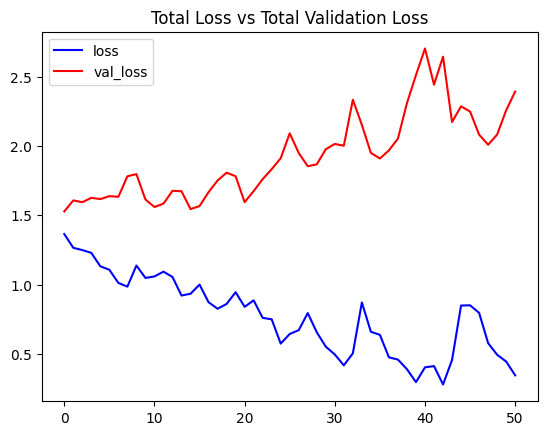

In [ ]:
# Visualize the training and validation loss metrices.
plot_metric(LRCN_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

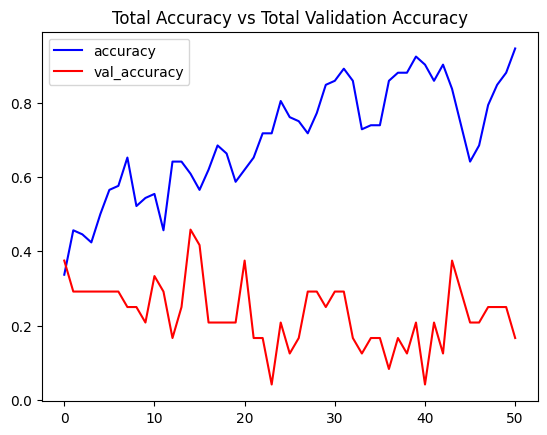

In [ ]:
# Visualize the training and validation accuracy metrices.
plot_metric(LRCN_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')

# dropout(0.5) batch size 32

In [ ]:
# Create an Instance of Early Stopping Callback.
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 50, mode = 'min', restore_best_weights = True)

# Compile the model and specify loss function, optimizer and metrics to the model.
LRCN_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

batch_size = 32

# Start training the model.
LRCN_model_training_history = LRCN_model.fit(x = features_train, y = labels_train, epochs = 100, batch_size = batch_size ,
                                             shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback])

Epoch 1/100
3/3 [==============================] - 13s 3s/step - loss: 1.2997 - accuracy: 0.3804 - val_loss: 1.5521 - val_accuracy: 0.2917
Epoch 2/100
3/3 [==============================] - 1s 437ms/step - loss: 1.2160 - accuracy: 0.4783 - val_loss: 1.5922 - val_accuracy: 0.3333
Epoch 3/100
3/3 [==============================] - 1s 433ms/step - loss: 1.1980 - accuracy: 0.4348 - val_loss: 1.6088 - val_accuracy: 0.3333
Epoch 4/100
3/3 [==============================] - 1s 431ms/step - loss: 1.1800 - accuracy: 0.4783 - val_loss: 1.6332 - val_accuracy: 0.3750
Epoch 5/100
3/3 [==============================] - 1s 427ms/step - loss: 1.1306 - accuracy: 0.5217 - val_loss: 1.6071 - val_accuracy: 0.3750
Epoch 6/100
3/3 [==============================] - 1s 429ms/step - loss: 1.0958 - accuracy: 0.5761 - val_loss: 1.6411 - val_accuracy: 0.2917
Epoch 7/100
3/3 [==============================] - 1s 430ms/step - loss: 0.9424 - accuracy: 0.6196 - val_loss: 1.7020 - val_accuracy: 0.2500
Epoch 8/100
3/3

In [ ]:
# Evaluate the trained model.
model_evaluation_history = LRCN_model.evaluate(features_test, labels_test)

1/1 [==============================] - 0s 315ms/step - loss: 1.4639 - accuracy: 0.3448


In [ ]:
# Get the loss and accuracy from model_evaluation_history.
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history

# Define the string date format.
# Get the current Date and Time in a DateTime Object.
# Convert the DateTime object to string according to the style mentioned in date_time_format string.
date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)

# Define a useful name for our model to make it easy for us while navigating through multiple saved models.
model_file_name = f'LRCN_model___Date_Time_{current_date_time_string}___Loss_{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}___BatchSize_{batch_size}___AddDropout(0.5).h5'

# Save the Model.
model_file_path = '/content/drive/MyDrive/Final_team_3/Code/Sunmyeong/LRCN_model/' + model_file_name
LRCN_model.save(model_file_path)

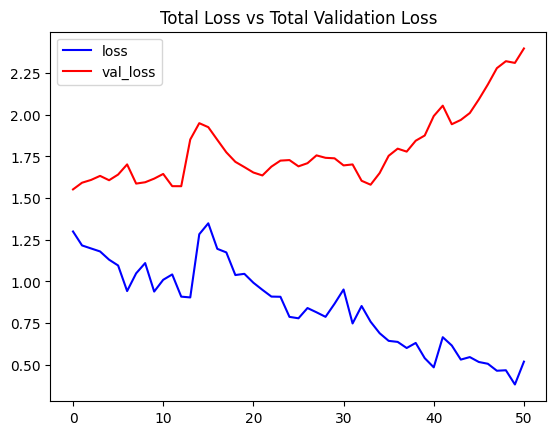

In [ ]:
# Visualize the training and validation loss metrices.
plot_metric(LRCN_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

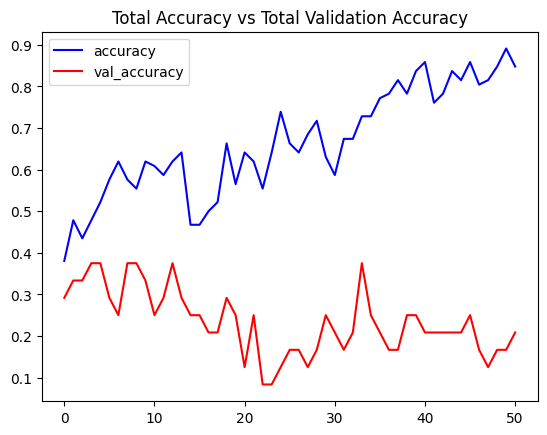

In [ ]:
# Visualize the training and validation accuracy metrices.
plot_metric(LRCN_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')

# dropout(0.5) batch size 64

In [ ]:
# Create an Instance of Early Stopping Callback.
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 50, mode = 'min', restore_best_weights = True)

# Compile the model and specify loss function, optimizer and metrics to the model.
LRCN_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

batch_size = 64

# Start training the model.
LRCN_model_training_history = LRCN_model.fit(x = features_train, y = labels_train, epochs = 100, batch_size = batch_size ,
                                             shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback])

Epoch 1/100


ResourceExhaustedError: ignored

In [ ]:
# Evaluate the trained model.
model_evaluation_history = LRCN_model.evaluate(features_test, labels_test)